### Importing all modules

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

### Import full dataset

In [2]:
df = pd.read_csv('full_tokenized_dataframe')

#### Balace data set (50k each)

In [3]:
fake_sample = df[df['type'] == 1].sample(n=50000, random_state=123)

In [4]:
reliable_sample = df[df['type'] == 0].sample(n=50000, random_state=123)

In [5]:
df_balanced = pd.concat([fake_sample, reliable_sample])
df_balanced['content']

75392     ['news', 'string', 'moder', 'earthquak', 'erup...
260211    ['news', 'stun', 'ministri', 'foreign', 'affai...
181614    ['turn', 'wast', 'plastic', 'bag', 'back', 'fu...
308589    ['star', 'trek', 'discoveri', 'discoveri', 'wa...
59949     ['pleas', 'post', 'import', 'pleas', 'look', '...
                                ...                        
130898    ['photo', 'updat', 'friday', 'even', 'presid',...
281911    ['hawkinsroland', 'j', 'manhattan', 'remsenbur...
183492    ['duncandorothi', 'belov', 'mother', 'shaun', ...
188025    ['elton', 'brand', 'score', 'point', 'help', '...
238269    ['entir', 'legal', 'landscap', 'chang', 'said'...
Name: content, Length: 100000, dtype: object

### Perform Tf-idf

In [25]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
x, y = df_balanced['content'], df_balanced['type']
x_train, x_nontrain, y_train, y_nontrain = train_test_split(x,y, test_size=0.2)
x_val, x_test, y_val, y_test = train_test_split(x_nontrain, y_nontrain, test_size=0.5)

In [26]:
x_train_vectorized = vectorizer.fit_transform(x_train)
x_val_vectorized = vectorizer.transform(x_val)

In [27]:
y_train = y_train.astype('int64')
y_val = y_val.astype('int64')

In [28]:
x_test_vectorized = vectorizer.transform(x_test)
y_test = y_test.astype('int64')

# Random Forest

In [30]:
rf = RandomForestClassifier(max_depth=200, random_state=0)

In [31]:
rf.fit(x_train_vectorized, y_train)

RandomForestClassifier(max_depth=200, random_state=0)

In [32]:
rf_acc = rf.score(x_val_vectorized, y_val)
print(f"The accuracy of the best performing random forest classifer is: {rf_acc}")

The accuracy of the best performing random forest classifer is: 0.9416


In [33]:
rf_y_pred = rf.predict(x_test_vectorized)
f1_score(y_test, rf_y_pred)

0.9401925508120198

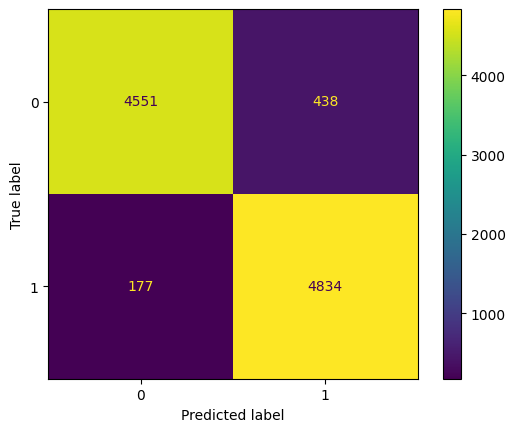

In [38]:
#Confusion matrix for RF
cm_rf = confusion_matrix(y_test, rf_y_pred, labels=rf.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf.classes_)
disp_rf.plot()
plt.savefig('rf_confusion_matrix.png')
plt.show()

In [37]:
# Classification report for RF
from sklearn.metrics import classification_report
rf_report = classification_report(y_test, rf_y_pred, output_dict = True)
rf_report['1'] # fake

{'precision': 0.9169195751138088,
 'recall': 0.9646777090401117,
 'f1-score': 0.9401925508120198,
 'support': 5011.0}

# Support Vector Machines

In [9]:
svm_clf = LinearSVC(dual="auto")

svm_parameters = [{
    "C": [0.001, 0.01, 0.1, 1, 10] 
}]

svm_grid_search = GridSearchCV(svm_clf, svm_parameters, cv=5, scoring="accuracy", return_train_score=True)

svm_grid_search.fit(x_train_vectorized, y_train)

best_svm = svm_grid_search.best_estimator_

best_svm

LinearSVC(C=10, dual='auto')

In [10]:
best_svm.score(x_val_vectorized,y_val)

0.9643

In [78]:
final_svm = LinearSVC(dual="auto", C=10)
final_svm.fit(x_train_vectorized, y_train)

LinearSVC(C=10, dual='auto')

In [80]:
final_svm.score(x_val_vectorized,y_val)

0.9601

In [101]:
x_val_vectorized.shape

(10000, 8217472)

#### Hyperparameter tuning of TfidfVectorizer for SVM:
Testing with SVC parameter grad: "C": [0.001, 0.01, 0.1, 1, 10]
- Default: 0.9496 -> (C=1)
- min_df=0.01, ngram_rand=(1,2): 0.9398 -> (C=1)
- min_df=0.01, max_df=0.99: 0.9371 -> (C=1)
- ngram_range(1,2): 0.9666 -> (C=10)
  
Testing with SVC parameter grad: "C": [0.001, 0.01, 0.1, 1, 100]
- ngram_range(1,2): failed to converge

### F-score evaluation

In [11]:
svm_y_pred = best_svm.predict(x_val_vectorized)

In [12]:
f1_score(y_val, svm_y_pred)

0.9640736640837275

### Confusion matrix

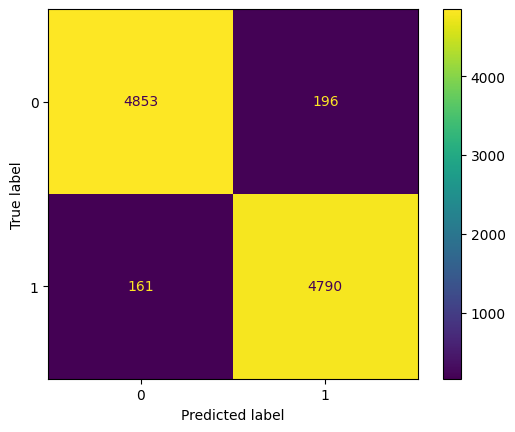

In [13]:
cm_svm = confusion_matrix(y_val, svm_y_pred, labels=best_svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=best_svm.classes_)
disp.plot()
plt.show()

# Logistic Regression

In [14]:
lr_clf = LogisticRegression(penalty="l2")

lr_parameters = [{
    "C": [100]
}]

lr_grid_search = GridSearchCV(lr_clf, lr_parameters, cv=3, scoring="accuracy", return_train_score=True)

lr_grid_search.fit(x_train_vectorized, y_train)

best_lr = lr_grid_search.best_estimator_

best_lr

LogisticRegression(C=100)

In [15]:
best_lr.score(x_val_vectorized,y_val)

0.9569

#### Hyperparameter tuning of TfidfVectorizer for SVM:
Testing with ngram_range(1,2)
- default: 0.953
- C=100,300 og penalty=None,l2: 0.9615
Testing with default tfidf
- 0.9434

### F-score evaluation

In [16]:
lr_y_pred = best_lr.predict(x_val_vectorized)

In [17]:
f1_score(y_val, lr_y_pred)

0.9564866229177184

### Confusion matrix

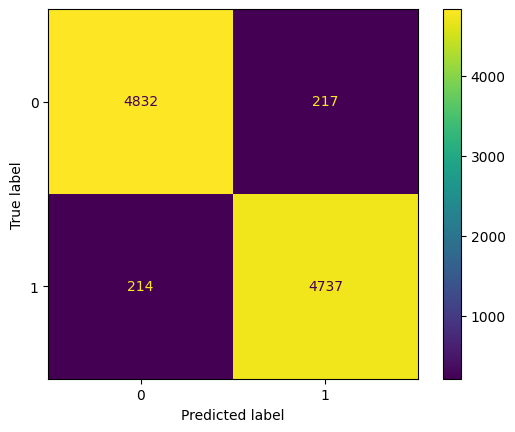

In [18]:
cm_lr = confusion_matrix(y_val, lr_y_pred, labels=best_lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=best_lr.classes_)
disp.plot()
plt.show()

# K-nearest

In [ ]:
knear_clf = KNeighborsClassifier()

knear_parameters = [{
    "n_neighbors": [3, 5, 7], "weights": ["distance"]
}]

knear_grid_search = GridSearchCV(knear_clf, knear_parameters, cv=5, scoring="accuracy", return_train_score=True)

knear_grid_search.fit(x_train_vectorized, y_train)

best_knear = knear_grid_search.best_estimator_

best_knear

In [ ]:
kn_clf = KNeighborsClassifier()
kn_clf.fit(x_train_vectorized, y_train)

kn_clf.score(x_val_vectorized,y_val)

### F-score evaluation

### Confusion matrix

# Naive Bayes

gnb_clf = GaussianNB()
x_train_NB = x_train_vectorized.toarray()
gnb.fit(x_train_NB, y_train)

x_val_vectorized_NB = x_val_vectorized.toarray()
gnb.score(x_val_vectorized_NB, y_val)

### Evaluation

In [61]:
liar_df = pd.read_csv('test.tsv', sep='\t', names=['id','label','statement','subject','speaker','speakers job','state info', 'party','credit1','credit2','credit3','credit4','credit5','context'])
liar_df.shape

(1267, 14)

In [62]:
type_names = ['true','mostly-true','half-true','barely-true','pants-fire','false']

type_counts = {}
for type_name in type_names:
    count = liar_df['label'].value_counts()[type_name]
    type_counts[type_name] = count

count_nan = liar_df["label"].isna().sum()
type_counts['nan'] = count_nan
print(type_counts)

{'true': 208, 'mostly-true': 241, 'half-true': 265, 'barely-true': 212, 'pants-fire': 92, 'false': 249, 'nan': 0}


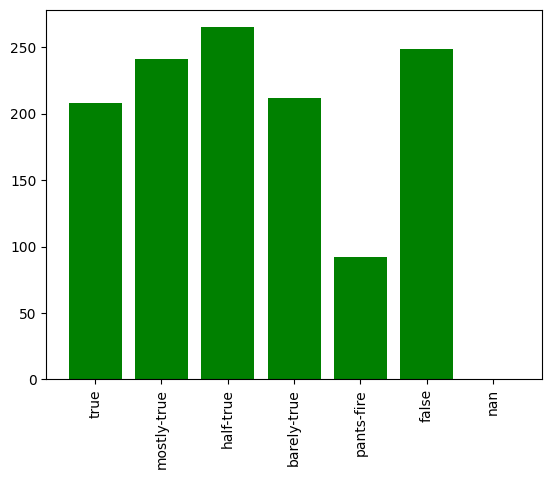

In [63]:
plt.bar(list(type_counts.keys()), type_counts.values(),color='g')
plt.xticks(rotation=90)
plt.show()

In [66]:
fake_real_df = liar_df[liar_df['label'].isin(['true','false'])]

In [68]:
fake_real_df.shape

(457, 14)

In [70]:
fake_real_df = fake_real_df.drop(['id','subject','speaker','speakers job','state info', 'party','credit1','credit2','credit3','credit4','credit5','context'],axis=1)

In [72]:
fake_real_df.loc[:, "label"] = fake_real_df.loc[:, "label"].apply(lambda x: 0 if x=="true" else 1)

In [74]:
fake_real_df.head()

,label,statement
0,0,Building a wall on the U.S.-Mexico border will...
1,1,Wisconsin is on pace to double the number of l...
2,1,Says John McCain has done nothing to help the ...
5,0,Over the past five years the federal governmen...
6,0,Says that Tennessee law requires that schools ...


In [94]:
#liar_vectorizer = TfidfVectorizer(ngram_range=(1,2))
x_liar, y_liar = fake_real_df['statement'], fake_real_df['label']
x_liar_vectorized = vectorizer.transform(x_liar)

In [102]:
y_liar = y_liar.astype('int64')

In [103]:
final_svm.score(x_liar_vectorized,y_liar)

0.5076586433260394